# Importing Lines

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from collections import Counter

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Hyperparams

In [2]:
SEED = 43

# Read-in Data

In [3]:
PATH = '../res/npy_img/left/'
files = glob(PATH+'*.npy')

In [15]:
sample = torch.tensor(np.load(files[0]))
x, y, f = np.load(files[0]).shape

In [32]:
def data_loader(files):
    out = []
    x, y, f = np.load(files[0]).shape
    for file in tqdm(files):
        file = np.load(file)
        out.append(file.transpose(2, 0, 1))
    out = np.array(out)
    return torch.tensor(out, dtype=torch.float)

In [33]:
np.load(files[0]).shape

(307, 375, 6)

In [34]:
X = data_loader(files)

In [35]:
label = pd.read_csv('../res/age_balanced.csv', index_col=0)
y_multi = torch.tensor(label.multiclass.values)
y_binary = torch.tensor(label.binary.values)

In [36]:
# Binary
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary,
                                                                  test_size=0.2, random_state=SEED)
train_binary_ds = TensorDataset(X_train, y_binary_train)
test_binary_ds = TensorDataset(X_test, y_binary_test)
train_binary_loader = DataLoader(train_binary_ds, batch_size=64, shuffle=True)
test_binary_loader = DataLoader(test_binary_ds, batch_size=64, shuffle=True)

sample_multi_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_multi_loader = DataLoader(sample_multi_ds)

In [43]:
# Binary
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi,
                                                                test_size=0.2, random_state=SEED)
train_multi_ds = TensorDataset(X_train, y_multi_train)
test_multi_ds = TensorDataset(X_test, y_multi_test)
train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
test_multi_loader = DataLoader(test_multi_ds, batch_size=128, shuffle=True)

sample_binary_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_binary_loader = DataLoader(sample_binary_ds)

# Functions in Need

In [11]:
def count(y_pred, y_true):
    y_pred_ = y_pred.argmax(axis=1)
    
    corr = 0
    for p, t in zip(y_pred_, y_true):
        if p == t:
            corr += 1
            
    return corr

# Model Implementation

## Model

In [37]:
class ConvNet(nn.Module):
    def __init__(self, ctype):
        super(ConvNet, self).__init__()
        self.ctype = ctype
        if self.ctype=='binary':
            out_node = 1
            self.last_layer = F.sigmoid
        elif self.ctype=='multi':
            out_node = 10
            self.last_layer = F.softmax
        else:
            pass
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(6, 10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        
        self.fc1 = nn.Linear(480, 100)
        self.fc2 = nn.Linear(100, out_node)

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        out = self.last_layer(out)
        return out

## Functions need in Future

In [38]:
def acc_multi(pred, true):
    result = 0
    cnt = 0
    for p, t in zip(pred.argmax(axis=1), true):
        cnt += 1
        if p == t:
            result += 1
            
    return result, cnt

In [39]:
def acc_binary(pred, true):
    correct, cnt = 0, 0
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, t in zip(pred, true):
        cnt += 1
        if (p >= 0.5) & (t == 1):
            correct += 1
            tp += 1
            
        elif (p >= 0.5) & (t == 0):
            fp += 1
            
        elif (p < 0.5) & (t == 1):
            tn += 1
            
        elif (p < 0.5) & (t == 0):
            correct += 1
            fn += 1
        
        else:
            pass
        
    return correct, cnt, np.array([tp, tn, fp, fn])

In [40]:
def to_binary(data):
    result = []
    for d in data:
        if d >= 0.5:
            result.append(1)
        elif d < 0.5:
            result.append(0)
    return result

## Debugging

In [41]:
conv = ConvNet(ctype='binary')
for x, y in sample_binary_loader:
    print(conv(x))

NameError: name 'sample_binary_loader' is not defined

In [44]:
conv = ConvNet(ctype='multi')
for x, y in train_multi_loader:
    print(conv(x).argmax(axis=1))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 2, 2, 2, 8, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 9, 2, 7, 2, 2,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 9, 7, 4, 2, 2,
        3, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 3, 2, 2, 2, 2, 7, 0, 2, 2, 0,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 7, 2, 2, 9, 2, 2, 5, 3,
        3, 2, 2, 2, 2, 3, 1, 2], grad_fn=<NotImplemented>)
tensor([2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 9, 2, 7, 4, 0, 9, 2, 2, 2, 2, 3, 2,
        2, 4, 7, 2, 3, 2, 9, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 5, 2, 0, 2, 3, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 3, 3, 5, 2, 2, 2, 3, 2, 2, 2,
        2, 2, 1, 2, 2, 0, 2, 2, 2, 3, 7, 2, 2, 2, 0, 2, 2, 7, 2, 2, 2, 2, 8, 2,
        3, 8, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 4, 2, 1, 2, 7, 2, 3, 2, 2, 7, 2,
        2, 2, 2, 3, 2, 2, 2, 0], grad_fn=<NotImplemented>)
tensor([2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 8, 2, 2, 0,
  

## Weighting

In [45]:
multi_weight = sorted(Counter(label.multiclass).items(), key=(lambda x: x[0]))
multi_weight = 1 / np.array([w[1] for w in multi_weight])

In [16]:
binary_weight = sorted(Counter(label.binary).items(), key=(lambda x: x[0]))
binary_weight = 1 / np.array([w[1] for w in binary_weight])

## Training - Multiclass

In [50]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='multi')

EPOCHS = range(1000)
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(multi_weight))
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_multi_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t = acc_multi(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_multi_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t = acc_multi(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        #print("Prediction: {}".format(y_pred.argmax(axis=1)))
        #print("Prediction: {}".format(y_pred[:3]))
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH: 0
[LOSS] train: 13.839, val: 4.611
[ACC%] train: 9.24%, val: 8.05%
EPOCH: 1
[LOSS] train: 13.834, val: 4.616
[ACC%] train: 10.1%, val: 9.2%
EPOCH: 2
[LOSS] train: 13.811, val: 4.611
[ACC%] train: 12.84%, val: 9.2%
EPOCH: 3
[LOSS] train: 13.811, val: 4.61
[ACC%] train: 13.13%, val: 9.2%
EPOCH: 4
[LOSS] train: 13.812, val: 4.611
[ACC%] train: 10.39%, val: 9.2%
EPOCH: 5
[LOSS] train: 13.813, val: 4.616
[ACC%] train: 11.98%, val: 9.2%
EPOCH: 6
[LOSS] train: 13.812, val: 4.61
[ACC%] train: 12.41%, val: 9.2%
EPOCH: 7
[LOSS] train: 13.812, val: 4.613
[ACC%] train: 12.84%, val: 9.2%
EPOCH: 8
[LOSS] train: 13.813, val: 4.611
[ACC%] train: 13.28%, val: 9.2%
EPOCH: 9
[LOSS] train: 13.805, val: 4.612
[ACC%] train: 11.4%, val: 8.05%
EPOCH: 10
[LOSS] train: 13.81, val: 4.622
[ACC%] train: 11.98%, val: 8.05%
EPOCH: 11
[LOSS] train: 13.805, val: 4.619
[ACC%] train: 11.11%, val: 8.05%
EPOCH: 12
[LOSS] train: 13.805, val: 4.617
[ACC%] train: 11.26%, val: 8.05%
EPOCH: 13
[LOSS] train: 13.807, val:

EPOCH: 109
[LOSS] train: 10.743, val: 4.635
[ACC%] train: 67.97%, val: 9.2%
EPOCH: 110
[LOSS] train: 10.782, val: 4.664
[ACC%] train: 68.25%, val: 10.92%
EPOCH: 111
[LOSS] train: 10.733, val: 4.666
[ACC%] train: 68.4%, val: 12.07%
EPOCH: 112
[LOSS] train: 10.689, val: 4.635
[ACC%] train: 69.55%, val: 10.34%
EPOCH: 113
[LOSS] train: 10.779, val: 4.641
[ACC%] train: 69.41%, val: 13.79%
EPOCH: 114
[LOSS] train: 10.663, val: 4.649
[ACC%] train: 68.98%, val: 10.92%
EPOCH: 115
[LOSS] train: 10.663, val: 4.654
[ACC%] train: 70.56%, val: 10.92%
EPOCH: 116
[LOSS] train: 10.68, val: 4.663
[ACC%] train: 69.41%, val: 9.77%
EPOCH: 117
[LOSS] train: 10.634, val: 4.617
[ACC%] train: 71.0%, val: 14.94%
EPOCH: 118
[LOSS] train: 10.552, val: 4.638
[ACC%] train: 71.14%, val: 12.07%
EPOCH: 119
[LOSS] train: 10.624, val: 4.624
[ACC%] train: 71.57%, val: 9.77%
EPOCH: 120
[LOSS] train: 10.586, val: 4.653
[ACC%] train: 71.28%, val: 11.49%
EPOCH: 121
[LOSS] train: 10.622, val: 4.654
[ACC%] train: 71.28%, val: 

EPOCH: 216
[LOSS] train: 9.353, val: 4.671
[ACC%] train: 91.34%, val: 9.77%
EPOCH: 217
[LOSS] train: 9.4, val: 4.739
[ACC%] train: 89.9%, val: 6.9%
EPOCH: 218
[LOSS] train: 9.308, val: 4.669
[ACC%] train: 92.21%, val: 8.62%
EPOCH: 219
[LOSS] train: 9.283, val: 4.714
[ACC%] train: 92.06%, val: 6.9%
EPOCH: 220
[LOSS] train: 9.18, val: 4.68
[ACC%] train: 93.51%, val: 9.2%
EPOCH: 221
[LOSS] train: 9.299, val: 4.693
[ACC%] train: 91.77%, val: 10.92%
EPOCH: 222
[LOSS] train: 9.281, val: 4.719
[ACC%] train: 92.35%, val: 6.32%
EPOCH: 223
[LOSS] train: 9.211, val: 4.636
[ACC%] train: 92.64%, val: 10.92%
EPOCH: 224
[LOSS] train: 9.213, val: 4.654
[ACC%] train: 92.35%, val: 10.34%
EPOCH: 225
[LOSS] train: 9.186, val: 4.631
[ACC%] train: 93.65%, val: 10.34%
EPOCH: 226
[LOSS] train: 9.222, val: 4.654
[ACC%] train: 92.93%, val: 9.77%
EPOCH: 227
[LOSS] train: 9.224, val: 4.639
[ACC%] train: 92.78%, val: 12.64%
EPOCH: 228
[LOSS] train: 9.249, val: 4.658
[ACC%] train: 93.51%, val: 10.34%
EPOCH: 229
[LO

EPOCH: 324
[LOSS] train: 9.067, val: 4.722
[ACC%] train: 95.09%, val: 9.77%
EPOCH: 325
[LOSS] train: 8.991, val: 4.7
[ACC%] train: 96.39%, val: 8.62%
EPOCH: 326
[LOSS] train: 9.033, val: 4.67
[ACC%] train: 95.67%, val: 8.62%
EPOCH: 327
[LOSS] train: 9.05, val: 4.701
[ACC%] train: 94.95%, val: 9.77%
EPOCH: 328
[LOSS] train: 9.06, val: 4.726
[ACC%] train: 95.38%, val: 7.47%
EPOCH: 329
[LOSS] train: 9.149, val: 4.658
[ACC%] train: 94.37%, val: 9.2%
EPOCH: 330
[LOSS] train: 9.033, val: 4.654
[ACC%] train: 95.82%, val: 10.92%
EPOCH: 331
[LOSS] train: 9.004, val: 4.674
[ACC%] train: 96.54%, val: 10.34%
EPOCH: 332
[LOSS] train: 9.049, val: 4.656
[ACC%] train: 95.53%, val: 8.62%
EPOCH: 333
[LOSS] train: 9.047, val: 4.733
[ACC%] train: 95.38%, val: 6.9%
EPOCH: 334
[LOSS] train: 9.041, val: 4.7
[ACC%] train: 95.96%, val: 9.77%
EPOCH: 335
[LOSS] train: 9.05, val: 4.684
[ACC%] train: 96.54%, val: 10.34%
EPOCH: 336
[LOSS] train: 9.034, val: 4.752
[ACC%] train: 95.09%, val: 6.9%
EPOCH: 337
[LOSS] tr

EPOCH: 432
[LOSS] train: 8.991, val: 4.658
[ACC%] train: 95.82%, val: 11.49%
EPOCH: 433
[LOSS] train: 9.054, val: 4.663
[ACC%] train: 95.24%, val: 12.64%
EPOCH: 434
[LOSS] train: 9.071, val: 4.679
[ACC%] train: 94.95%, val: 10.34%
EPOCH: 435
[LOSS] train: 9.02, val: 4.601
[ACC%] train: 95.96%, val: 13.79%
EPOCH: 436
[LOSS] train: 9.071, val: 4.621
[ACC%] train: 95.24%, val: 13.22%
EPOCH: 437
[LOSS] train: 9.007, val: 4.608
[ACC%] train: 96.1%, val: 13.22%
EPOCH: 438
[LOSS] train: 9.091, val: 4.705
[ACC%] train: 95.38%, val: 9.2%
EPOCH: 439
[LOSS] train: 9.057, val: 4.694
[ACC%] train: 95.09%, val: 9.77%
EPOCH: 440
[LOSS] train: 9.042, val: 4.65
[ACC%] train: 95.24%, val: 11.49%
EPOCH: 441
[LOSS] train: 9.042, val: 4.617
[ACC%] train: 95.53%, val: 14.37%
EPOCH: 442
[LOSS] train: 9.056, val: 4.695
[ACC%] train: 95.53%, val: 11.49%
EPOCH: 443
[LOSS] train: 9.105, val: 4.642
[ACC%] train: 94.95%, val: 12.07%
EPOCH: 444
[LOSS] train: 8.952, val: 4.68
[ACC%] train: 97.11%, val: 10.34%
EPOCH:

EPOCH: 540
[LOSS] train: 8.89, val: 4.658
[ACC%] train: 97.84%, val: 11.49%
EPOCH: 541
[LOSS] train: 8.97, val: 4.699
[ACC%] train: 96.39%, val: 10.92%
EPOCH: 542
[LOSS] train: 8.951, val: 4.633
[ACC%] train: 96.54%, val: 10.92%
EPOCH: 543
[LOSS] train: 8.964, val: 4.668
[ACC%] train: 97.11%, val: 9.77%
EPOCH: 544
[LOSS] train: 9.01, val: 4.618
[ACC%] train: 95.96%, val: 13.22%
EPOCH: 545
[LOSS] train: 8.985, val: 4.654
[ACC%] train: 97.11%, val: 13.22%
EPOCH: 546
[LOSS] train: 8.914, val: 4.723
[ACC%] train: 97.84%, val: 10.92%
EPOCH: 547
[LOSS] train: 9.017, val: 4.705
[ACC%] train: 96.1%, val: 9.77%
EPOCH: 548
[LOSS] train: 8.936, val: 4.659
[ACC%] train: 96.97%, val: 13.22%
EPOCH: 549
[LOSS] train: 8.933, val: 4.684
[ACC%] train: 96.97%, val: 10.92%
EPOCH: 550
[LOSS] train: 8.911, val: 4.697
[ACC%] train: 97.98%, val: 11.49%
EPOCH: 551
[LOSS] train: 8.958, val: 4.671
[ACC%] train: 97.11%, val: 11.49%
EPOCH: 552
[LOSS] train: 8.946, val: 4.675
[ACC%] train: 97.26%, val: 10.92%
EPOCH

EPOCH: 648
[LOSS] train: 9.027, val: 4.74
[ACC%] train: 96.1%, val: 7.47%
EPOCH: 649
[LOSS] train: 9.025, val: 4.696
[ACC%] train: 95.82%, val: 9.77%
EPOCH: 650
[LOSS] train: 9.151, val: 4.773
[ACC%] train: 94.08%, val: 8.62%
EPOCH: 651
[LOSS] train: 9.103, val: 4.763
[ACC%] train: 94.81%, val: 6.9%
EPOCH: 652
[LOSS] train: 9.044, val: 4.78
[ACC%] train: 95.67%, val: 5.17%
EPOCH: 653
[LOSS] train: 9.1, val: 4.704
[ACC%] train: 94.37%, val: 9.77%
EPOCH: 654
[LOSS] train: 8.97, val: 4.691
[ACC%] train: 96.39%, val: 12.07%
EPOCH: 655
[LOSS] train: 9.015, val: 4.73
[ACC%] train: 96.25%, val: 10.92%
EPOCH: 656
[LOSS] train: 9.072, val: 4.748
[ACC%] train: 94.81%, val: 6.32%
EPOCH: 657
[LOSS] train: 9.102, val: 4.712
[ACC%] train: 94.37%, val: 8.05%
EPOCH: 658
[LOSS] train: 9.015, val: 4.703
[ACC%] train: 95.53%, val: 8.62%
EPOCH: 659
[LOSS] train: 9.047, val: 4.715
[ACC%] train: 95.09%, val: 10.34%
EPOCH: 660
[LOSS] train: 9.063, val: 4.713
[ACC%] train: 95.38%, val: 7.47%
EPOCH: 661
[LOSS]

EPOCH: 756
[LOSS] train: 8.908, val: 4.655
[ACC%] train: 97.4%, val: 12.07%
EPOCH: 757
[LOSS] train: 8.946, val: 4.619
[ACC%] train: 97.11%, val: 13.79%
EPOCH: 758
[LOSS] train: 8.965, val: 4.657
[ACC%] train: 96.97%, val: 12.07%
EPOCH: 759
[LOSS] train: 8.945, val: 4.659
[ACC%] train: 96.83%, val: 11.49%
EPOCH: 760
[LOSS] train: 9.031, val: 4.659
[ACC%] train: 95.53%, val: 11.49%
EPOCH: 761
[LOSS] train: 9.027, val: 4.677
[ACC%] train: 95.24%, val: 12.07%
EPOCH: 762
[LOSS] train: 9.104, val: 4.695
[ACC%] train: 94.08%, val: 9.77%
EPOCH: 763
[LOSS] train: 8.997, val: 4.761
[ACC%] train: 95.53%, val: 8.62%
EPOCH: 764
[LOSS] train: 9.12, val: 4.702
[ACC%] train: 94.23%, val: 8.62%
EPOCH: 765
[LOSS] train: 9.044, val: 4.592
[ACC%] train: 94.95%, val: 13.79%
EPOCH: 766
[LOSS] train: 9.031, val: 4.705
[ACC%] train: 96.1%, val: 12.07%
EPOCH: 767
[LOSS] train: 9.011, val: 4.607
[ACC%] train: 96.25%, val: 13.79%
EPOCH: 768
[LOSS] train: 9.04, val: 4.702
[ACC%] train: 95.53%, val: 9.2%
EPOCH: 7

EPOCH: 864
[LOSS] train: 8.972, val: 4.609
[ACC%] train: 96.25%, val: 13.79%
EPOCH: 865
[LOSS] train: 8.94, val: 4.612
[ACC%] train: 96.97%, val: 14.37%
EPOCH: 866
[LOSS] train: 8.917, val: 4.68
[ACC%] train: 97.26%, val: 12.64%
EPOCH: 867
[LOSS] train: 9.043, val: 4.678
[ACC%] train: 95.38%, val: 12.64%
EPOCH: 868
[LOSS] train: 8.958, val: 4.584
[ACC%] train: 96.54%, val: 14.94%
EPOCH: 869
[LOSS] train: 8.957, val: 4.612
[ACC%] train: 97.11%, val: 13.22%
EPOCH: 870
[LOSS] train: 8.993, val: 4.649
[ACC%] train: 95.96%, val: 12.64%
EPOCH: 871
[LOSS] train: 8.932, val: 4.667
[ACC%] train: 96.83%, val: 10.34%
EPOCH: 872
[LOSS] train: 8.903, val: 4.655
[ACC%] train: 97.98%, val: 12.07%
EPOCH: 873
[LOSS] train: 8.923, val: 4.65
[ACC%] train: 97.11%, val: 11.49%
EPOCH: 874
[LOSS] train: 8.974, val: 4.676
[ACC%] train: 96.83%, val: 13.22%
EPOCH: 875
[LOSS] train: 8.935, val: 4.68
[ACC%] train: 97.4%, val: 12.64%
EPOCH: 876
[LOSS] train: 8.913, val: 4.688
[ACC%] train: 97.98%, val: 11.49%
EPOC

EPOCH: 972
[LOSS] train: 9.084, val: 4.739
[ACC%] train: 94.37%, val: 9.2%
EPOCH: 973
[LOSS] train: 9.121, val: 4.675
[ACC%] train: 93.94%, val: 12.07%
EPOCH: 974
[LOSS] train: 9.076, val: 4.685
[ACC%] train: 94.95%, val: 9.77%
EPOCH: 975
[LOSS] train: 9.154, val: 4.708
[ACC%] train: 93.51%, val: 9.77%
EPOCH: 976
[LOSS] train: 9.113, val: 4.788
[ACC%] train: 94.23%, val: 6.9%
EPOCH: 977
[LOSS] train: 9.079, val: 4.752
[ACC%] train: 94.52%, val: 9.77%
EPOCH: 978
[LOSS] train: 8.978, val: 4.661
[ACC%] train: 96.39%, val: 13.22%
EPOCH: 979
[LOSS] train: 9.116, val: 4.64
[ACC%] train: 94.23%, val: 12.07%
EPOCH: 980
[LOSS] train: 9.113, val: 4.647
[ACC%] train: 94.08%, val: 13.79%
EPOCH: 981
[LOSS] train: 9.159, val: 4.608
[ACC%] train: 93.51%, val: 13.22%
EPOCH: 982
[LOSS] train: 9.059, val: 4.673
[ACC%] train: 95.24%, val: 13.22%
EPOCH: 983
[LOSS] train: 9.065, val: 4.619
[ACC%] train: 94.52%, val: 12.07%
EPOCH: 984
[LOSS] train: 9.02, val: 4.636
[ACC%] train: 95.96%, val: 13.22%
EPOCH: 9

[]

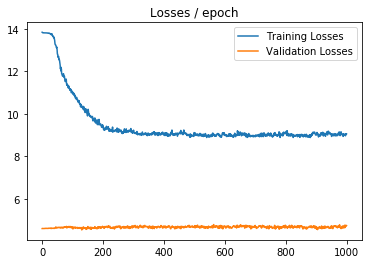

In [51]:
plt.title("Losses / epoch")
plt.plot(train_losses, label='Training Losses')
plt.plot(val_losses, label='Validation Losses')
plt.legend()
plt.plot()

[]

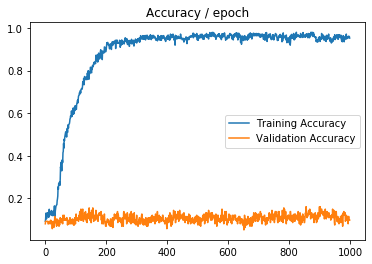

In [52]:
plt.title("Accuracy / epoch")
plt.plot(np.array(train_accs)/train_cnt, label='Training Accuracy')
plt.plot(np.array(val_accs)/val_cnt, label='Validation Accuracy')
plt.legend()
plt.plot()

In [55]:
conv(x).argmax(axis=1)

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 6, 1, 6, 7, 5, 0, 2, 6, 5, 2, 0, 8, 7, 8, 7, 6, 3, 8, 8, 3, 7, 5, 8,
        4, 6, 2, 8, 3, 3, 3, 1, 8, 3, 1, 1, 2, 1, 4, 3, 1, 6, 2, 9, 0, 1],
       grad_fn=<NotImplemented>)

In [1]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='binary')

EPOCHS = range(100)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_binary_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_binary_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

NameError: name 'ConvNet' is not defined

In [72]:
pred = torch.tensor([0.1, 0.2, 0.3, 0.9], dtype=torch.float)
true = torch.tensor([0, 0, 0, 1], dtype=torch.float)
loss_fn(pred, true)

tensor(0.1976)